# Pyreflect Reflectivity Pipeline Example

This notebook demonstrates the example workflow with clearer, annotated steps. It shows how to go from neutron reflectivity (NR) curves to scattering length density (SLD) profiles using `pyreflect`.


## 1. Environment setup

Use the following cells to make sure PyTorch and pyreflect are available. Installation is commented out so you can enable it only if needed.


In [ ]:
# Uncomment if ipykernel is needed in this environment. Skip for windows.

# !curl -fsSLo setup.sh https://raw.githubusercontent.com/williamQyq/pyreflect/main/setup.sh
# !bash setup.sh

### 1.1 Install `pyreflect`

`Note`: Install may takes some times and restart Kernel after installation

In [ ]:
# Uncomment if pyreflect is not installed in this environment.
# Installation may takes some times
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple pyreflect==1.4.1

In [16]:
!pip show pyreflect

Name: pyreflect
Version: 1.4.1
Summary: The package tool for neutron reflectivity analysis
Home-page: https://github.com/williamQyq/pyreflect
Author: Yuqing Qiao
Author-email: qiao.yuqi@northeastern.edu
License-Expression: MIT
Location: c:\users\qyqfi\miniconda3\envs\pyreflect\lib\site-packages
Requires: llvmlite, numba, numpy, opencv-python, pandas, pyyaml, refl1d, refnx, scikit-learn, scipy, seaborn, torch, tqdm, typer
Required-by: 


In [4]:
import platform, sys, importlib

def safe_version(pkg):
    try:
        module = importlib.import_module(pkg)
        return getattr(module, "__version__", "unknown")
    except ModuleNotFoundError:
        return "not installed"

print(f"Python: {sys.version.split()[0]} ({platform.system()} {platform.release()})")
print(f"PyTorch: {safe_version('torch')}")

try:
    import torch
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA device:", torch.cuda.get_device_name(0))
except ModuleNotFoundError:
    pass

Python: 3.10.19 (Windows 10)
PyTorch: 2.5.1+cpu
CUDA available: False


## 2. Paths and data overview

We keep all paths together for clarity. The repo already ships generated train/test splits and a pretrained model so you can run inference quickly.


In [5]:
from pathlib import Path
import numpy as np
from pprint import pprint

ROOT = Path("../experiments/exp1_baseline")  # ← Recommended
# OR: ROOT = Path(r"C:\Users\rahej\Documents\Programming\Northeastern\CS 2535\pyreflect\experiments\exp1_baseline")

# Trained files from exp1_baseline
TRAIN_NR = ROOT / "data/curves/nr_train.npy"
TRAIN_SLD = ROOT / "data/curves/sld_train.npy"
PRETRAINED_MODEL = ROOT / "data/trained_nr_sld_model.pth"
NORMALIZATION_STAT = ROOT / "data/normalization_stat.npy"

# For testing, we'll use the same training data (we'll split it later)
TEST_NR = TRAIN_NR  # We'll take a slice for testing
TEST_SLD = TRAIN_SLD

# Verify files exist
print("Checking files...")
for name, path in [
    ("Training NR", TRAIN_NR),
    ("Training SLD", TRAIN_SLD),
    ("Model", PRETRAINED_MODEL),
    ("Norm Stats", NORMALIZATION_STAT)
]:
    if path.exists():
        print(f"✅ {name}: {path}")
    else:
        print(f"❌ {name}: {path} NOT FOUND")
        
print("\n✅ Setup complete!")

Checking files...
✅ Training NR: ..\experiments\exp1_baseline\data\curves\nr_train.npy
✅ Training SLD: ..\experiments\exp1_baseline\data\curves\sld_train.npy
✅ Model: ..\experiments\exp1_baseline\data\trained_nr_sld_model.pth
✅ Norm Stats: ..\experiments\exp1_baseline\data\normalization_stat.npy

✅ Setup complete!


## 2.1 Configuration Overview
We load and inspect the NR → SLD pipeline configuration:

Load settings.yml, then override the paths and hyperparameters to match the data above. Keep epochs small for a quick demo;

In [ ]:
# import sys
# !{sys.executable} -m pyreflect init --force

In [11]:
import pyreflect
from pyreflect.config import load_config
from pyreflect.input import NRSLDDataProcessor
import pyreflect.pipelines.reflectivity_pipeline as workflow
from pprint import pprint
import numpy as np

root = "../experiments/exp1_baseline"
config = pyreflect.config.load_config(root)

pprint(config['nr_predict_sld'])

{'file': {'nr_train': 'data/curves/nr_train.npy',
          'sld_train': 'data/curves/sld_train.npy'},
 'models': {'batch_size': 32,
            'dropout': 0.5,
            'epochs': 1,
            'layers': 12,
            'model': 'data/trained_nr_sld_model.pth',
            'normalization_stats': 'data/normalization_stat.npy',
            'num_curves': 10000,
            'num_film_layers': 5}}


## 3. Dataset Preparation
- We load pre-generated synthetic datasets (already shuffled):
    - NR curves: shape (N, 2, 308) → (Q, R)
    - SLD profiles: shape (N, 2, 900) → (z, ρ)

In [12]:
dproc = NRSLDDataProcessor(TRAIN_NR,TRAIN_SLD).load_data()
dproc._nr_arr.shape, dproc._sld_arr.shape

((10000, 2, 308), (10000, 2, 900))

## 4. Model Architecture & Training
### 4.1 Training Configuration

In [13]:
model_config = config["nr_predict_sld"]["models"]

# Match YOUR experiment settings
model_config["num_film_layers"] = 5
model_config["dropout"] = 0.5
model_config["epochs"] = 1
model_config["model"] = PRETRAINED_MODEL
model_config["layers"] = 12
model_config["normalization_stats"] = NORMALIZATION_STAT

file_config = config["nr_predict_sld"]["file"]
file_config["nr_train"] = TRAIN_NR
file_config["sld_train"] = TRAIN_SLD

from pyreflect.models.config import NRSLDModelTrainerParams

# Create trainer params
trainer_params = NRSLDModelTrainerParams(root=str(ROOT), _config=config)

print("✅ Model configuration set:")
print(f"   Layers: {model_config['layers']}")
print(f"   Dropout: {model_config['dropout']}")
print(f"   Epochs trained: {model_config['epochs']}")
print(f"   Model path: {PRETRAINED_MODEL}")

✅ Model configuration set:
   Layers: 12
   Dropout: 0.5
   Epochs trained: 1
   Model path: ..\experiments\exp1_baseline\data\trained_nr_sld_model.pth


### 4.2 Prepare a lightweight training set
The full training split is large; to keep the example snappy we take a small slice. Adjust train_slice as needed.

In [14]:
import pyreflect.pipelines.reflectivity_pipeline as workflow

# Preprocess the data (normalize, log transform, etc.)
X_train, y_train = workflow.preprocess(dproc, trainer_params.normalization_stats)

print(f"✅ Preprocessed data:")
print(f"   X_train (NR) shape: {X_train.shape}")
print(f"   y_train (SLD) shape: {y_train.shape}")
print(f"\nWhat happened:")
print(f"   - NR: log-transformed and normalized")
print(f"   - NR: Q channel removed (CNN only needs reflectivity)")
print(f"   - SLD: normalized to [0, 1] range")

✅ Preprocessed data:
   X_train (NR) shape: (10000, 1, 308)
   y_train (SLD) shape: (10000, 2, 900)

What happened:
   - NR: log-transformed and normalized
   - NR: Q channel removed (CNN only needs reflectivity)
   - SLD: normalized to [0, 1] range


## 5. Train or load a model

Set `use_pretrained=True` to skip training and use the bundled weights. Set it to `False` to run a short training session with the sliced data.

The trained model is automatically saved for reuse. The save model path will be `PRETRAINED_MODEL`

In [16]:
use_pretrained = True

pipeline = workflow.ReflectivityPipeline(None, trainer_params)

if use_pretrained:
    model = pipeline.load_model(str(PRETRAINED_MODEL))
    print("✅ Loaded YOUR trained model from exp1_baseline!")
else:
    model = workflow.train_nr_predict_sld_model(X_train, y_train, trainer_params, auto_save=True)

norm_stats = workflow.load_normalization_stat(str(NORMALIZATION_STAT))
print("✅ Loaded normalization stats")
print("\nYour model is ready to make predictions! 🚀")

C:\Users\rahej\Documents\Programming\Northeastern\CS 2535\pyreflect\src\pyreflect\pipelines\reflectivity_pipeline.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state

Loaded NR predict SLD model from: ..\experiments\exp1_baseline\data\trained_nr_sld_model.pth
✅ Loaded YOUR trained model from exp1_baseline!
✅ Loaded normalization stats

Your model is ready to make predictions! 🚀


## 6. Run inference on a test batch

We take a handful of test NR curves and predict their SLD profiles.

In [17]:
test_batch = 10
test_proc = NRSLDDataProcessor(TEST_NR, TEST_SLD).load_data()
nr_batch = test_proc._nr_arr[:test_batch]
true_sld = test_proc._sld_arr[:test_batch]

y_pred = pipeline.predict_sld(nr_batch, norm_stats, model)
print("Predictions shape:", np.asarray(y_pred).shape)

Predicted SLD shape: (10, 2, 900)
Predictions shape: (10, 2, 900)


## 7. Helper Function (Optional) — for Experimental Data

The experimental SLD–depth profile must be flipped so that it is oriented from the silicon substrate toward the air interface, ensuring consistency with the model’s prediction format.
Belows are helper function to do the flip and align points.

In [ ]:
# from pyreflect.pipelines import reverse_y_order, find_substrate_critical_idx, align_points

# usage:
# Flip SLD y from left to right, substrate to air direction
# reverse_y_order(sld_array)

# Align B to A
# aligned_arr = align_points(a,b)

## 8. Compute Neutron Reflectivity (NR) from SLD

This section defines a helper function to compute neutron reflectivity directly from the predicted SLD profile, enabling comparison with the ground-truth reflectivity to verify the training result.


In [19]:
import numpy as np
import pyreflect
from pyreflect.pipelines import compute_nr_from_sld

computed_nr = []

for i in range(test_batch):
    profile = np.asarray(y_pred[i])

    Q,R = compute_nr_from_sld(profile)
    # Stack Q and R → (2, nQ)
    QR = np.stack([Q, R], axis=0)
    computed_nr.append(QR)

# Stack samples → (10, 2, nQ)
computed_nr = np.stack(computed_nr)

print("Computed NR with predictions")
print(f"   Computed NR shape: {computed_nr.shape}")

Computed NR with predictions
   Computed NR shape: (10, 2, 400)


## 9. Visualization: Prediction vs GroundTruth -- NR & SLD Side-by-Side

- Left: Experimental NR vs NR recomputed from predicted SLD

- Right: Ground-truth SLD vs predicted SLD (with/without dropout)

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "DejaVu Sans"   # or "Arial"

def plot_experiment_results(expt_nr_data, expt_sld_data=None,
                            computed_nr_data=None, predicted_sld_data=None):
    """
    Publication-quality plot for AAAI paper: NR & SLD side-by-side.
    """

    # --- Matplotlib style for paper ---
    mpl.rcParams.update({
        "font.size": 8,              # base font size
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "lines.linewidth": 1.3,
        "figure.dpi": 300,
    })

    fig, axes = plt.subplots(1, 2, figsize=(6.8, 2.6))  # fits in 2-column width

    # --- Left: Reflectivity (NR) ---
    axes[0].plot(expt_nr_data[0], expt_nr_data[1],
                 color="black", alpha=0.8, linestyle="-",linewidth=2,
                 label="GroundTruth")
    if computed_nr_data is not None:
        axes[0].plot(computed_nr_data[0], computed_nr_data[1],
                     color="black", label="Computed NR", linestyle="--",linewidth=1.3)

    axes[0].set_xlabel("Q (Å⁻¹)")
    axes[0].set_ylabel("Reflectivity NR")
    axes[0].set_yscale("log")

    # Legend inside top-right, small box
    axes[0].legend(frameon=False, loc="lower left", handlelength=2.5)


    # --- Right: SLD Profiles ---
    if expt_sld_data is not None:
        axes[1].plot(expt_sld_data[0], expt_sld_data[1],
                     color="black", alpha=0.8, linestyle="-",linewidth=2,
                     label="GroundTruth")
    if predicted_sld_data is not None:
        axes[1].plot(predicted_sld_data[0], predicted_sld_data[1],
                     color="red", linestyle="--", label="No Dropout")

    # if dropout_sld_data is not None:
    #     axes[1].plot(dropout_sld_data[0], dropout_sld_data[1],
    #                  color="blue", linestyle="--", label="Dropout")

    axes[1].set_xlabel("Depth (Å)")
    axes[1].set_ylabel("SLD (×10⁻⁶ Å⁻²)")

    axes[1].legend(frameon=False, loc="lower left", handlelength=2.5)

    # --- Remove titles (paper captions describe them) ---
    for ax in axes:
        ax.set_title("")
        ax.tick_params(direction="in", length=2.5)

    plt.tight_layout(pad=1.0, w_pad=1.4)
    plt.show()
    return fig


Plotting sample 1/10


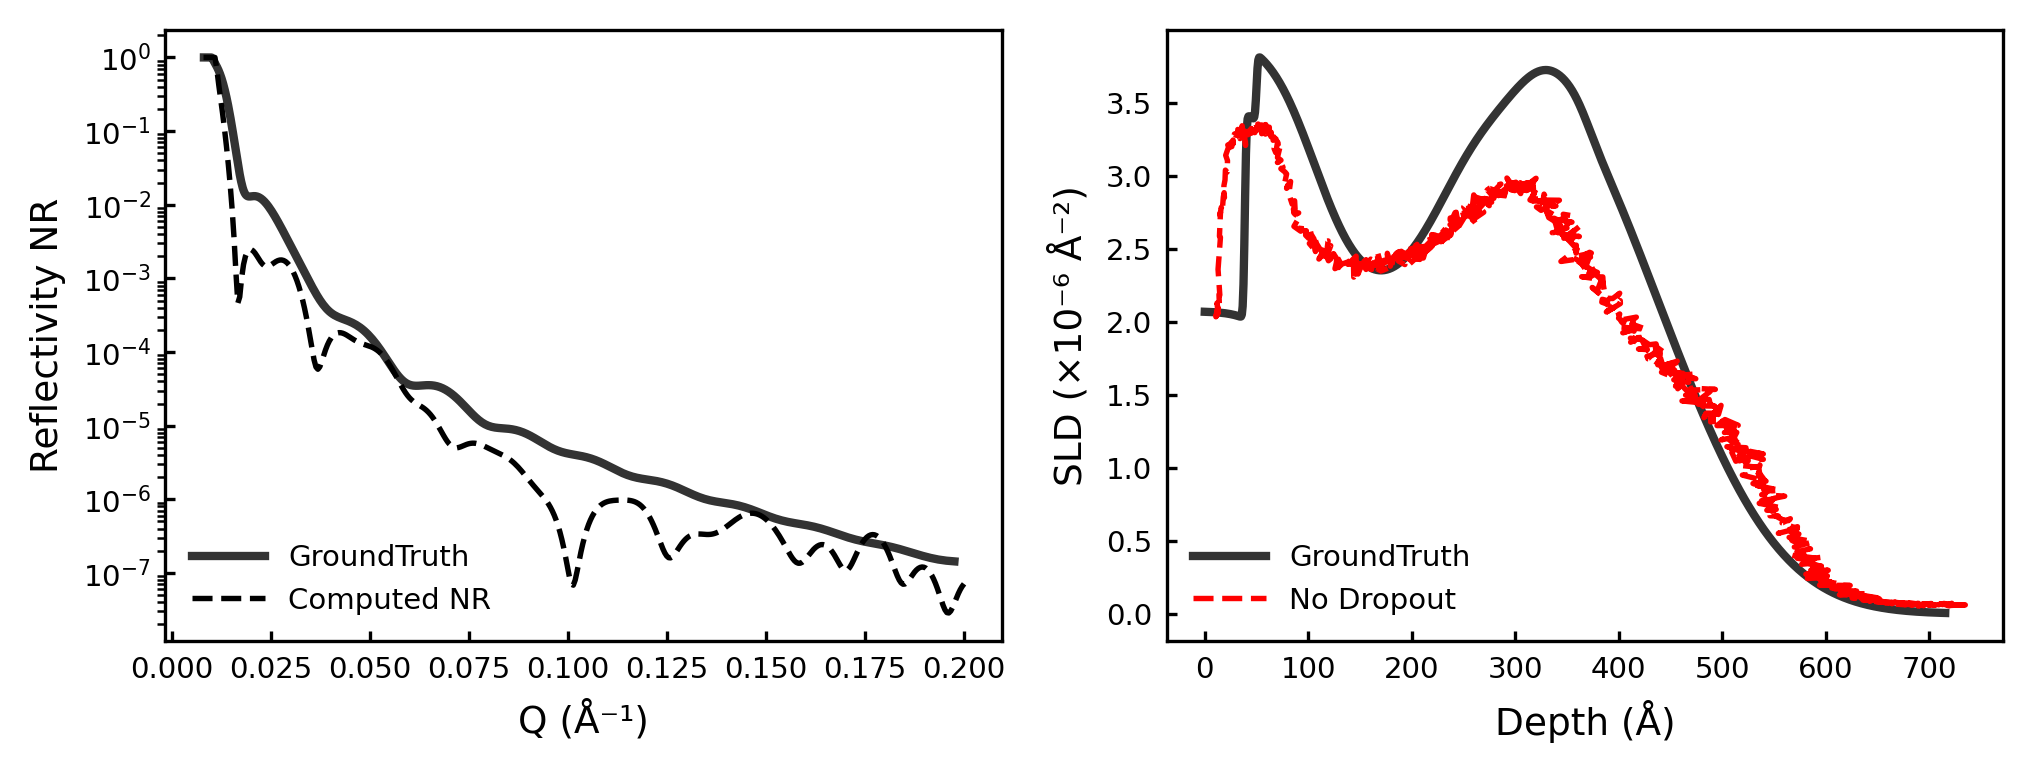

Plotting sample 2/10


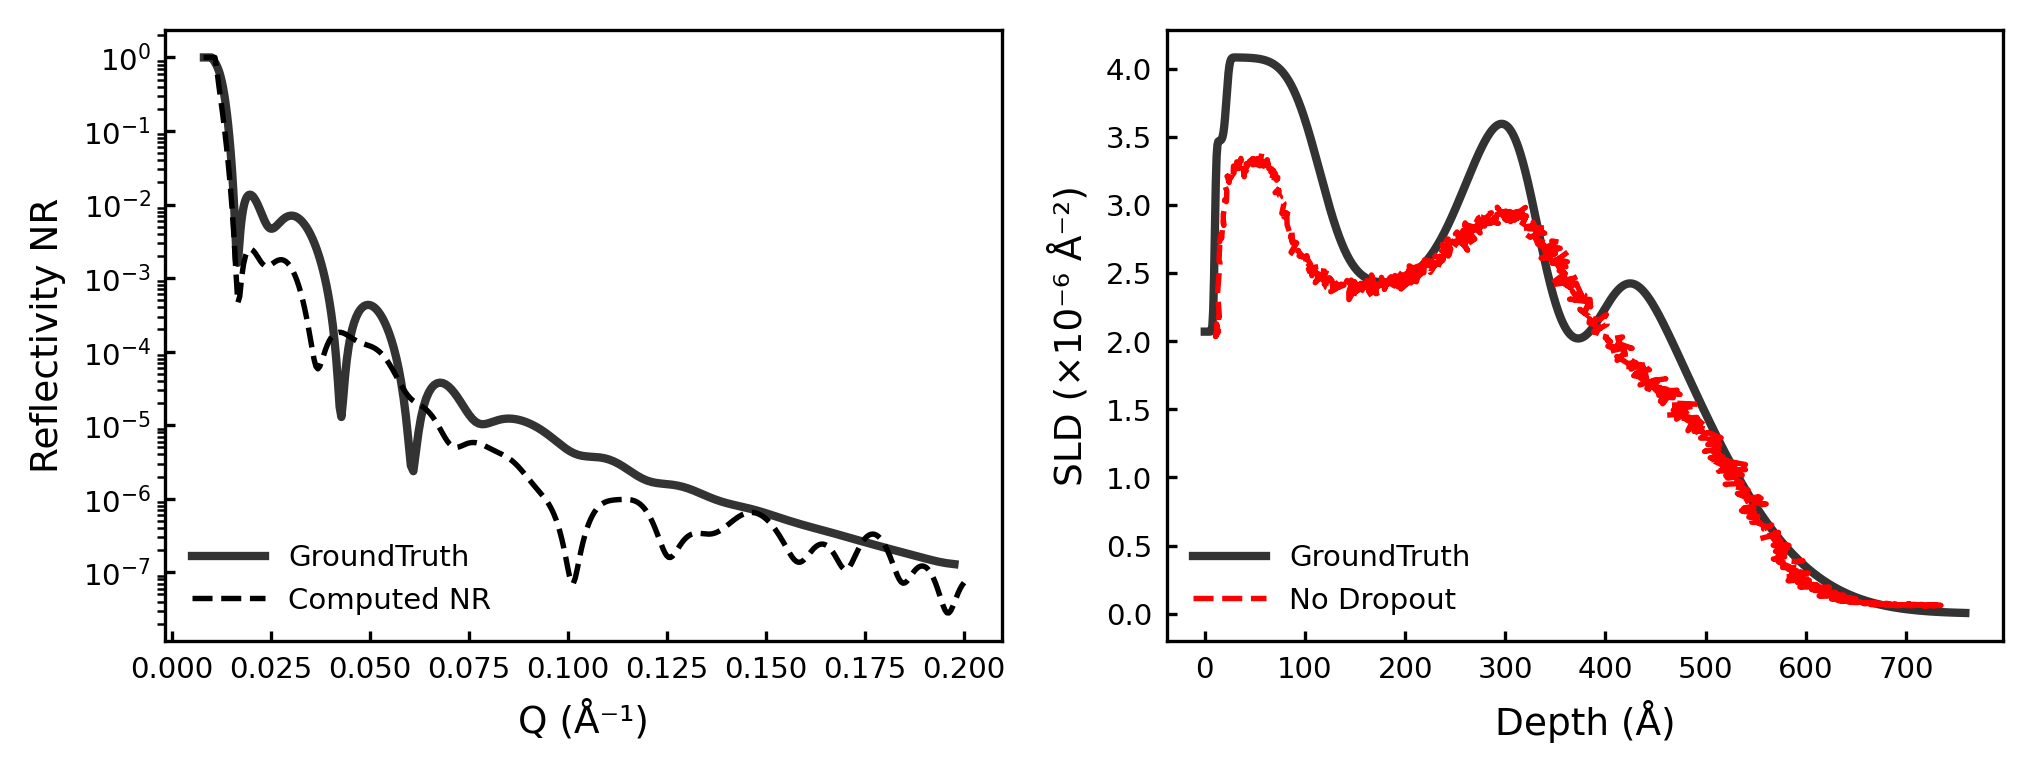

Plotting sample 3/10


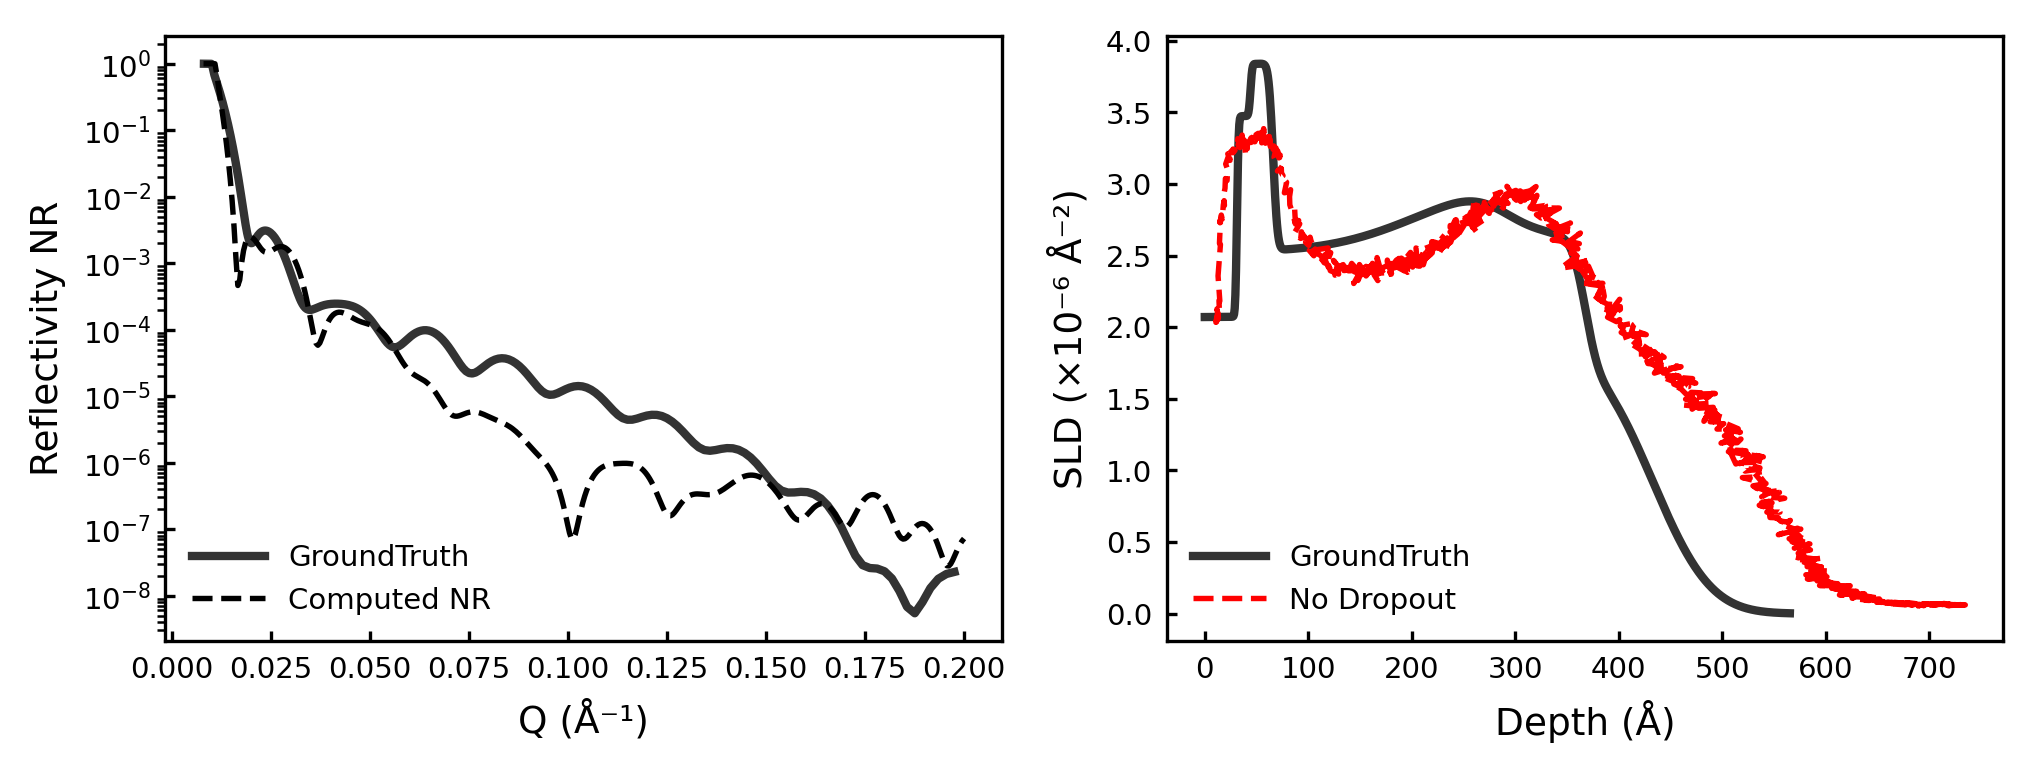

Plotting sample 4/10


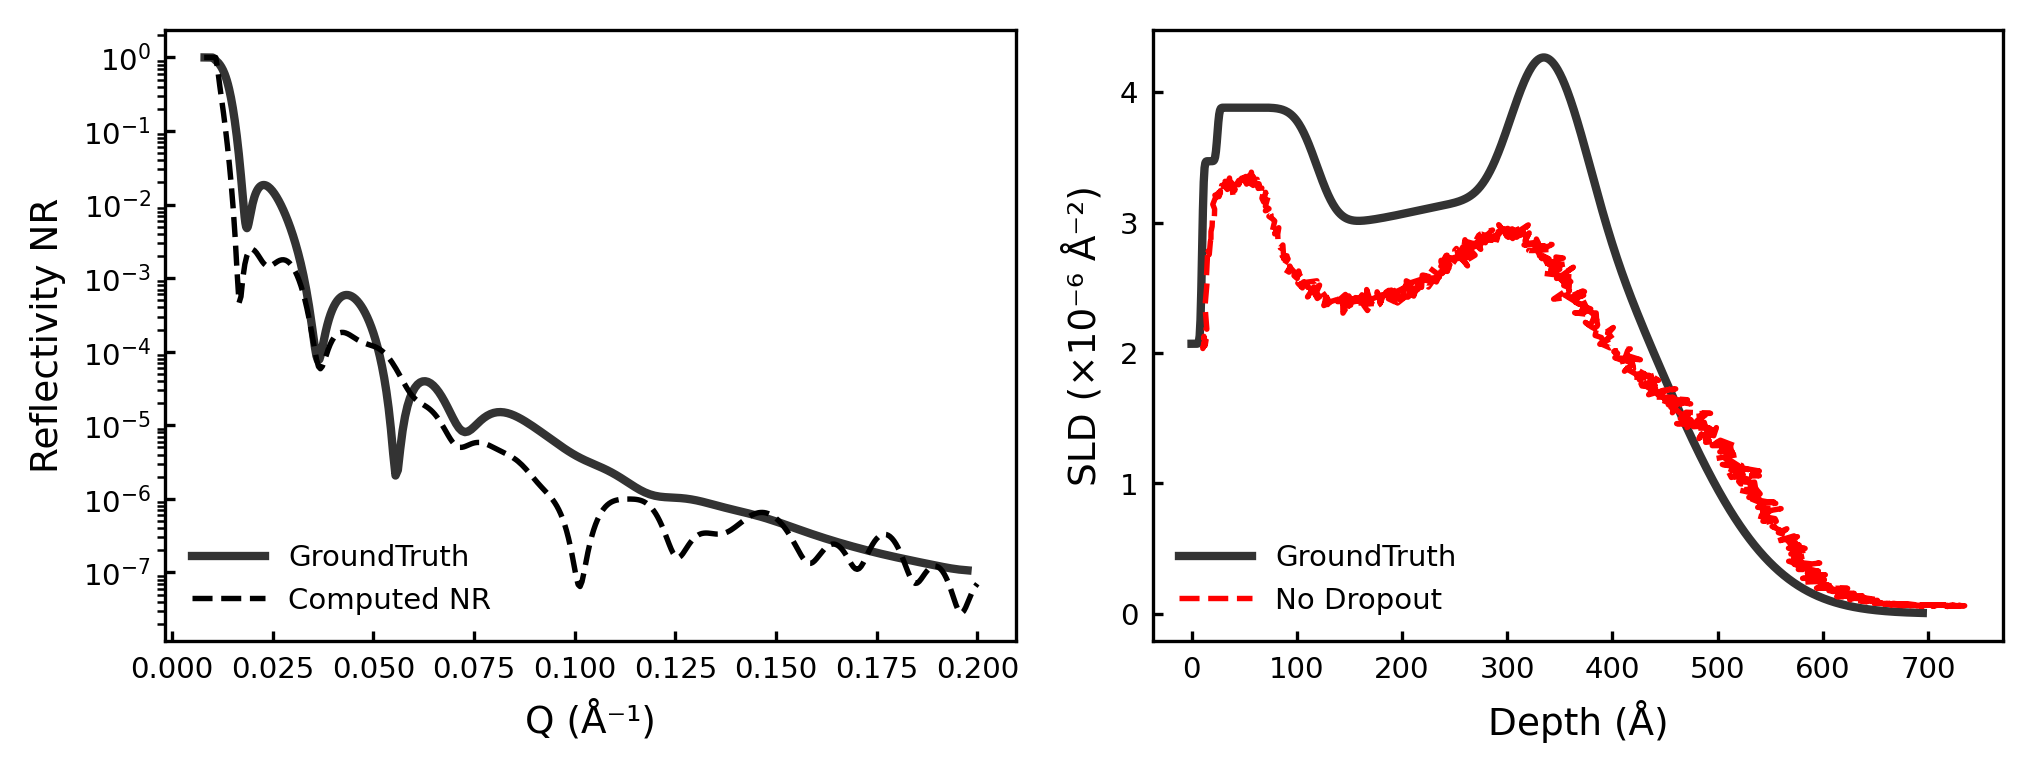

Plotting sample 5/10


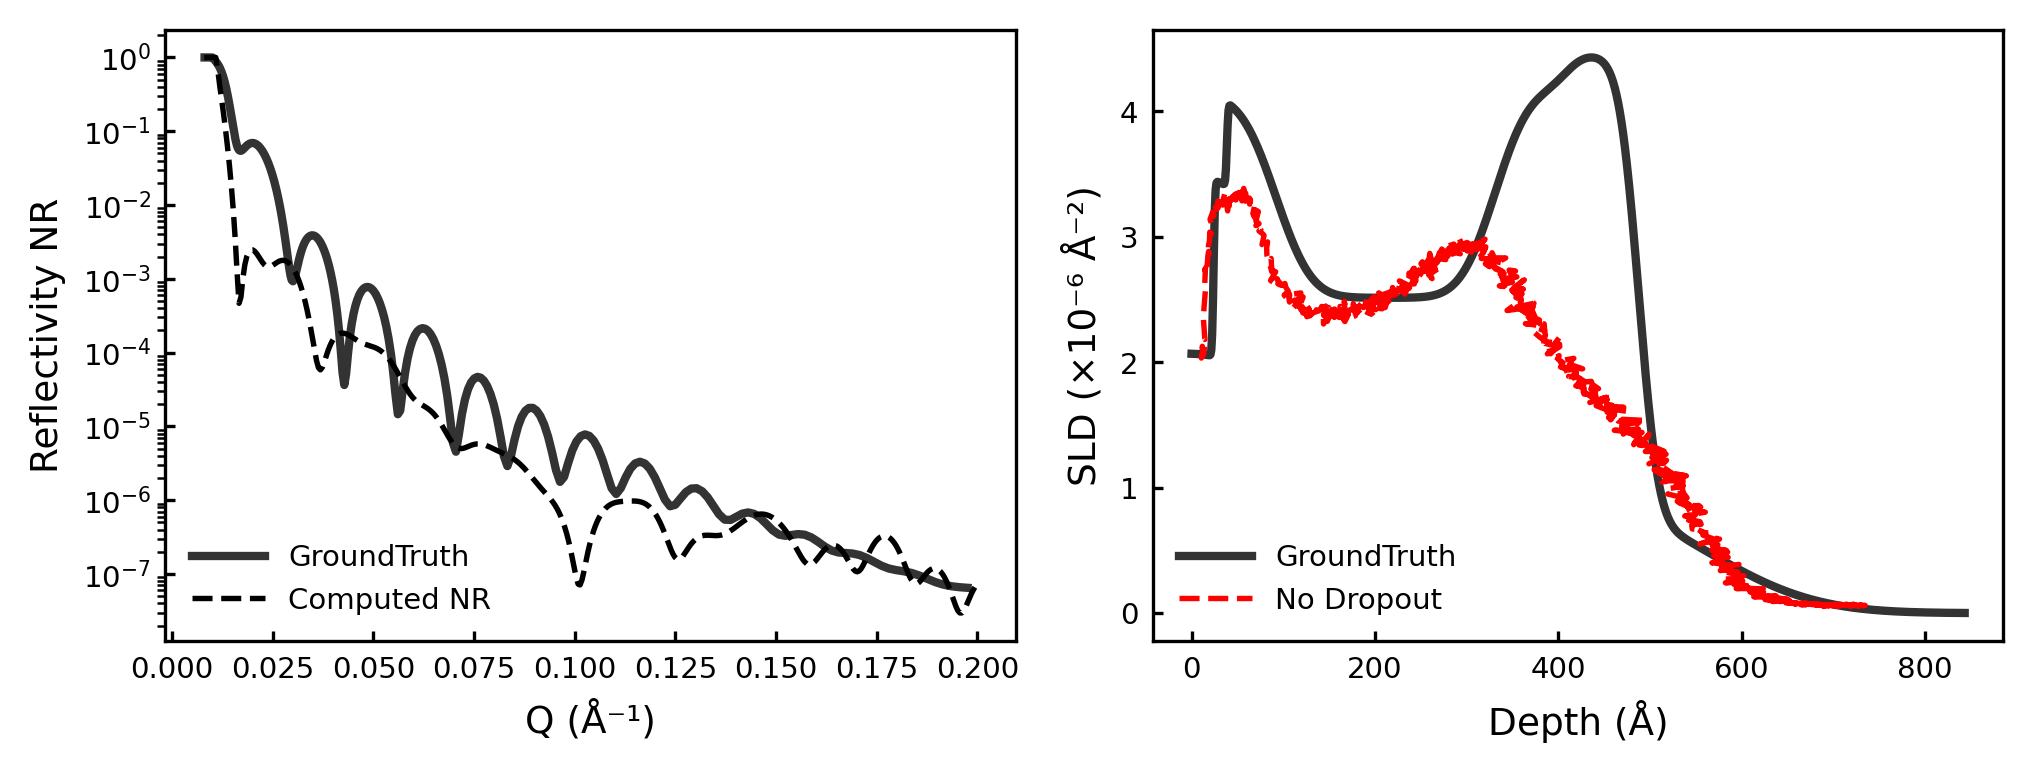

Plotting sample 6/10


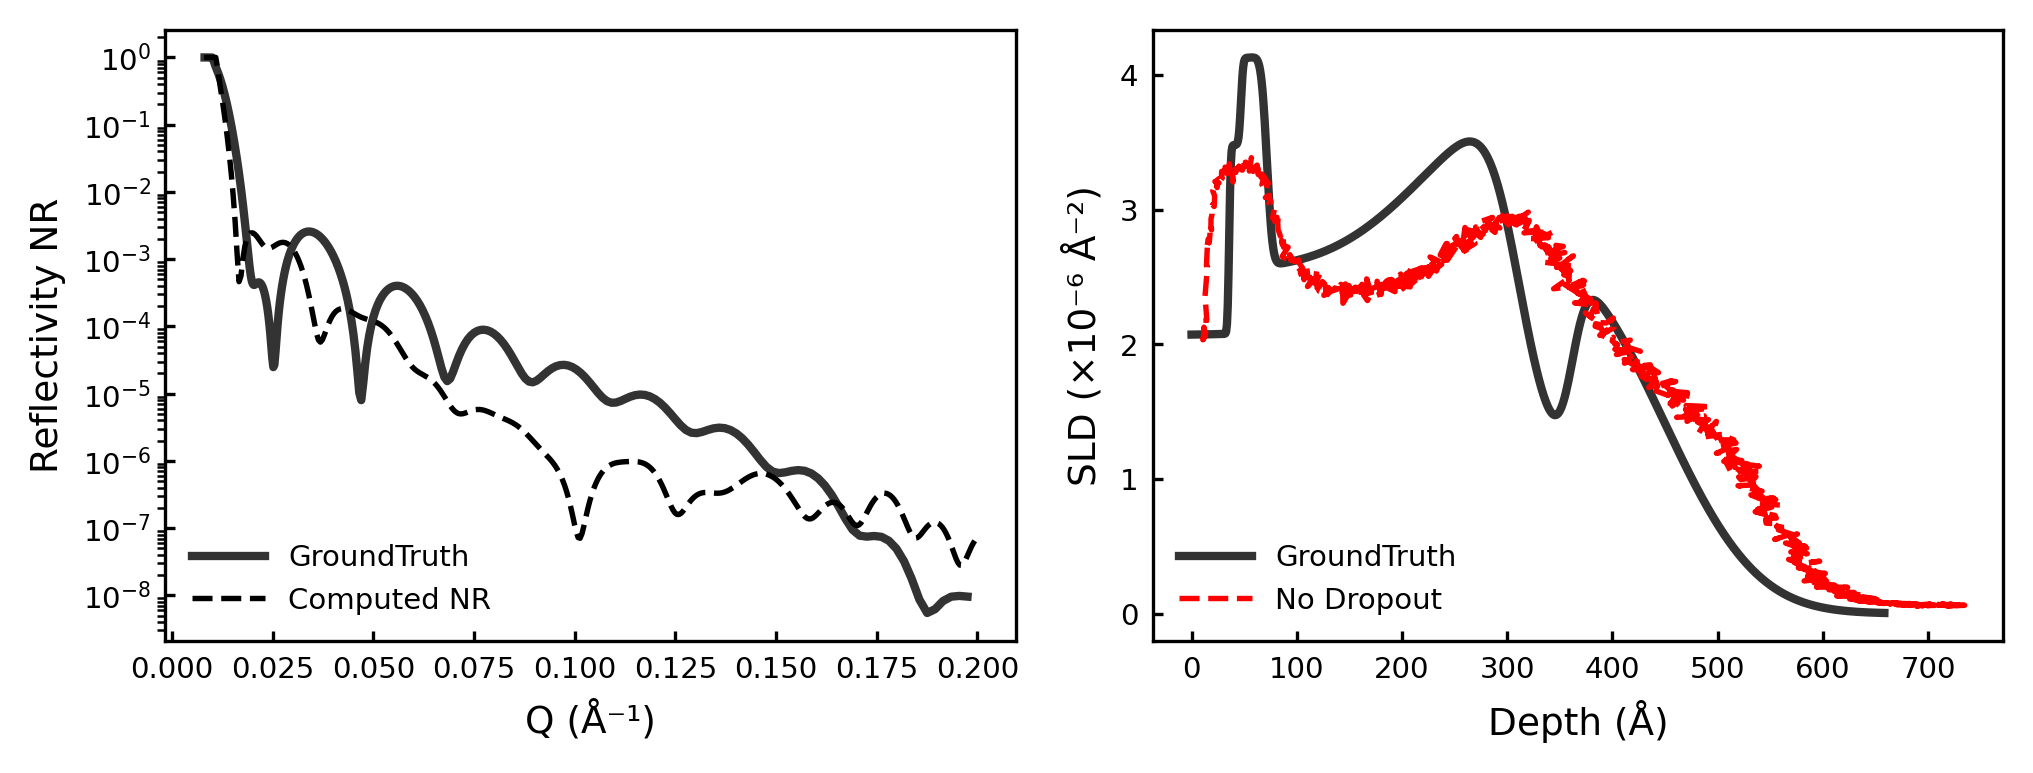

Plotting sample 7/10


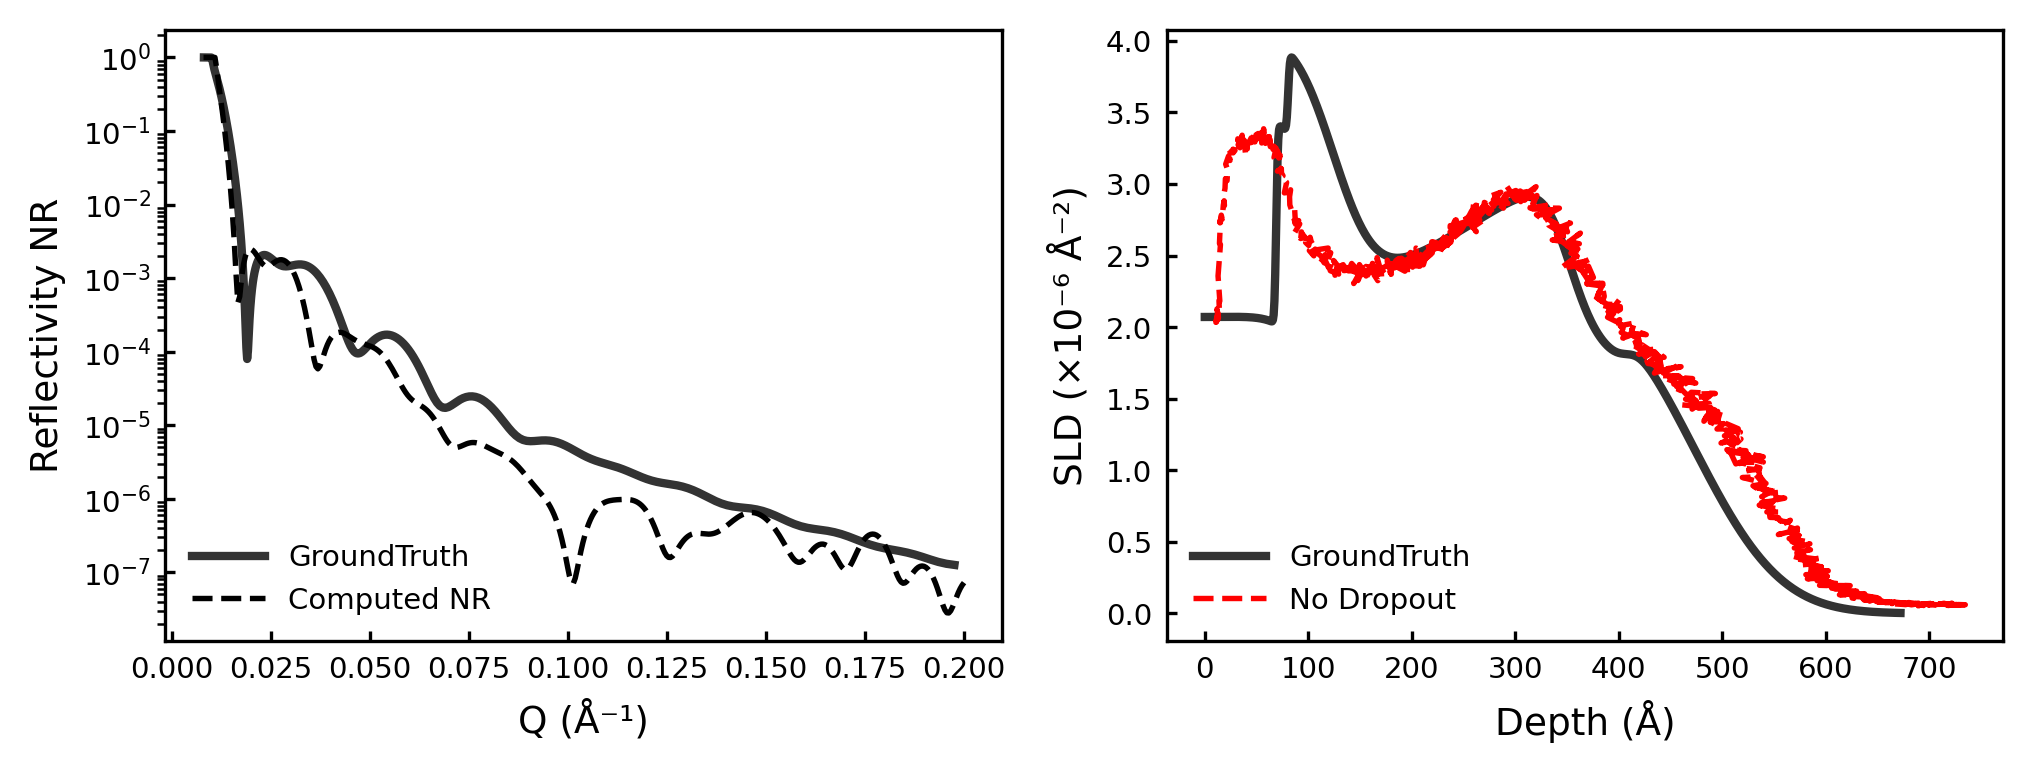

Plotting sample 8/10


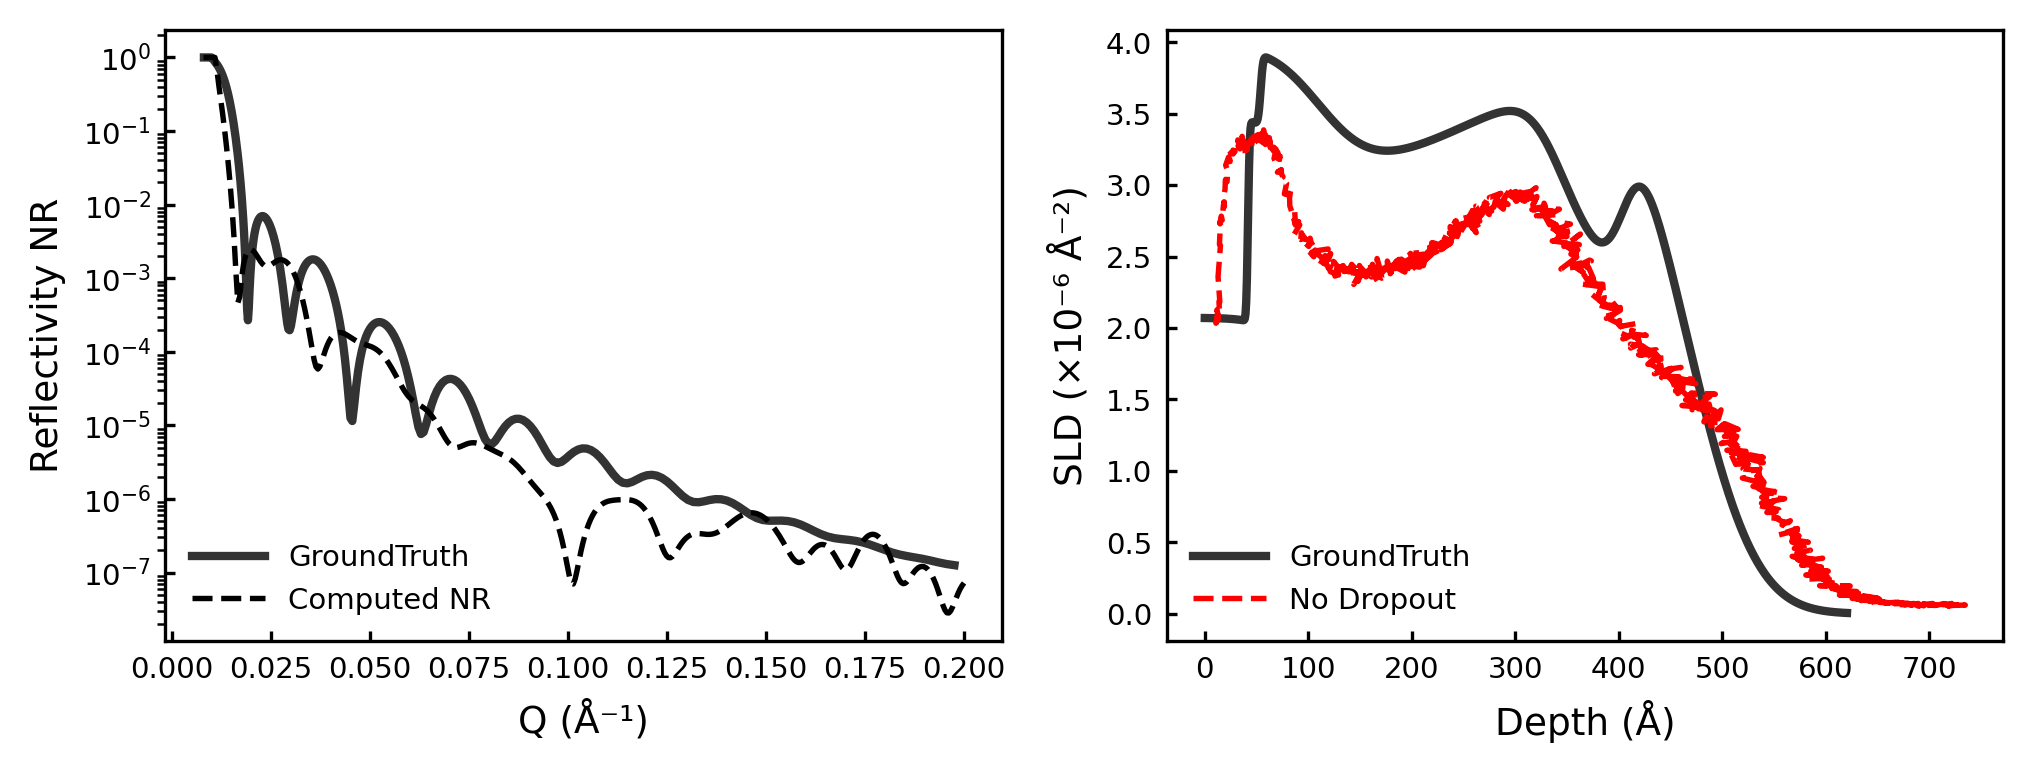

Plotting sample 9/10


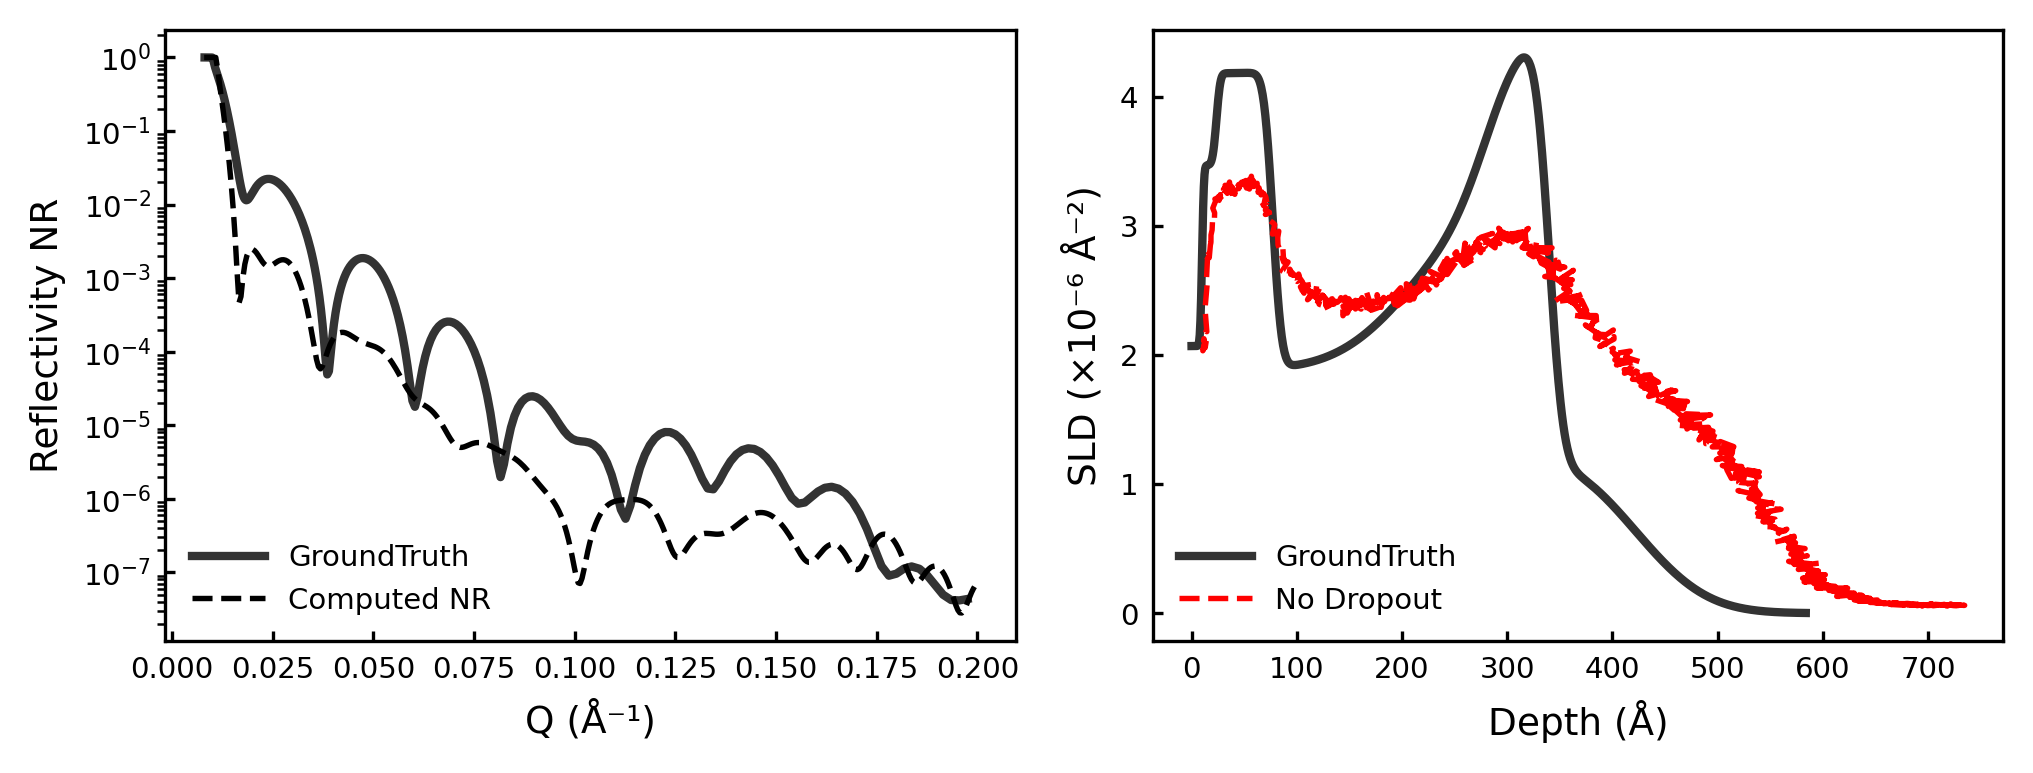

Plotting sample 10/10


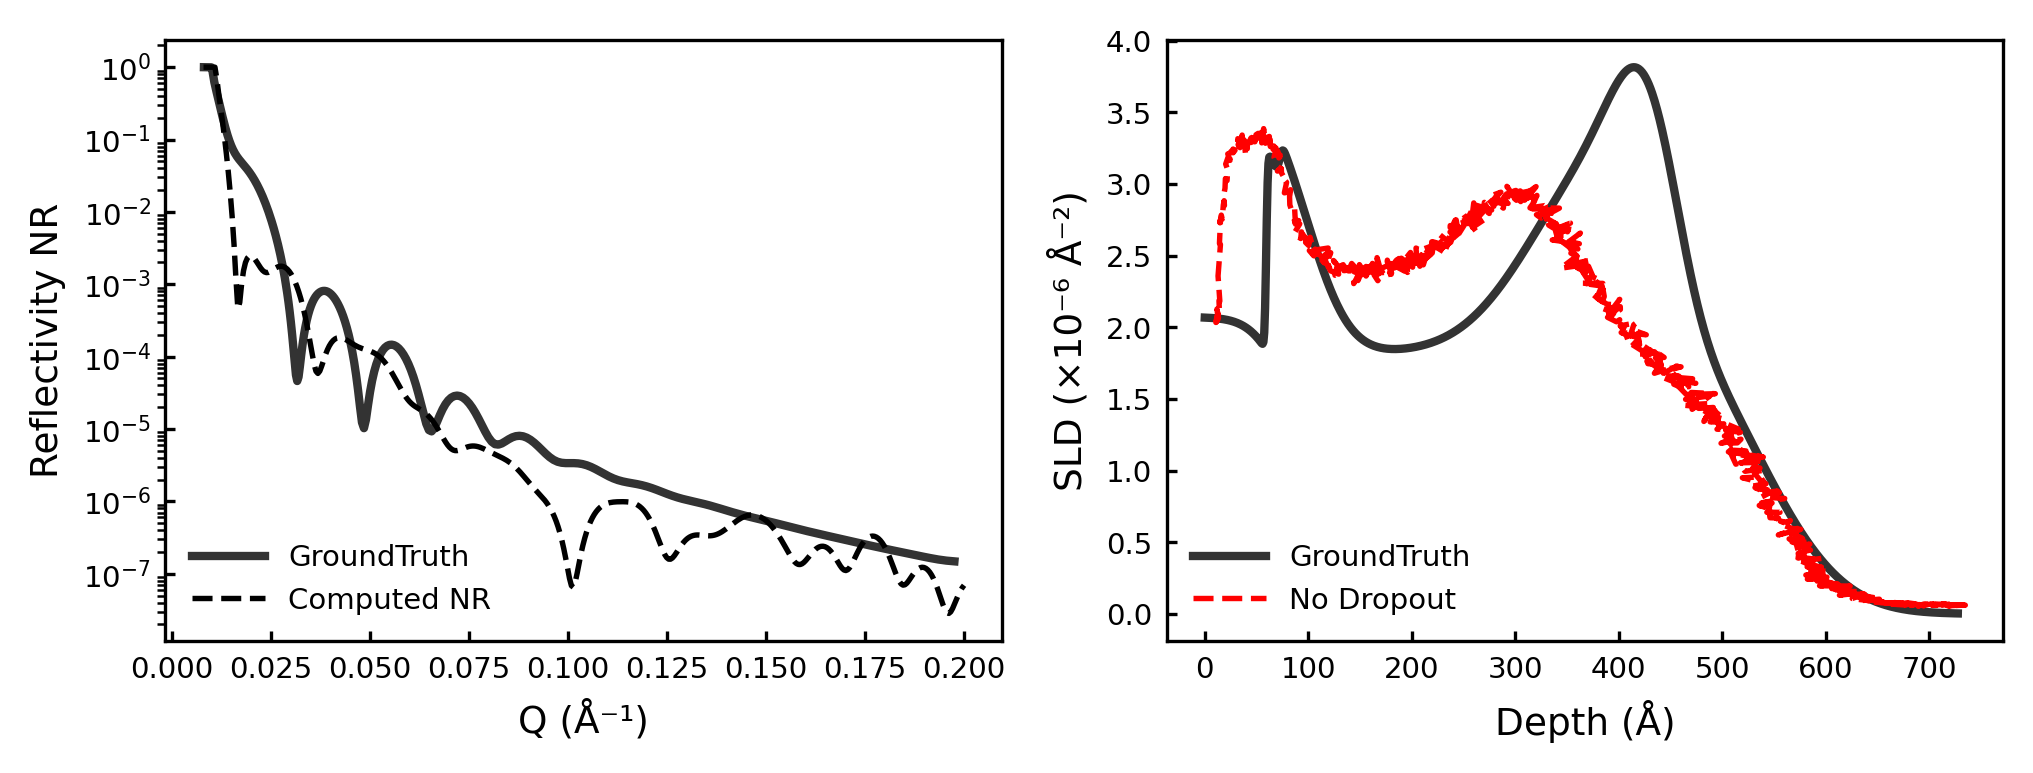

In [22]:
%matplotlib inline

test_batch = 10
test_proc = NRSLDDataProcessor(TEST_NR, TEST_SLD).load_data()
nr_batch = test_proc._nr_arr[:test_batch]
true_sld = test_proc._sld_arr[:test_batch]

for i in range(test_batch):
    print(f"Plotting sample {i+1}/{test_batch}")
    fig = plot_experiment_results(
        nr_batch[i],
        expt_sld_data=true_sld[i],
        computed_nr_data=computed_nr[i],
        predicted_sld_data=y_pred[i])